# Import Required Libraries
Import the necessary libraries, including pickle, numpy, torch, and others.

In [1]:
# Import Required Libraries
import pickle
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from typing import List, Set, Tuple
from graph import Graph
import networkx as nx

# Load Data
Load the data from 'data/graphs.dat' using pickle.

In [21]:
# Load Data
with open('data/graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

# Calculate Statistics
Calculate relevant statistics such as max_family_id and create a set of family_ids.

In [3]:
# Calculate Statistics

max_family_id = -1  # Initialize max_family_id
family_ids_set = set()  # Initialize set to store unique family_ids

# Iterate through all graphs to calculate statistics
for graph in graphs:
    parts = graph.get_parts()
    for part in parts:
        family_id = int(part.get_family_id())
        family_ids_set.add(family_id)
        max_family_id = max(family_id, max_family_id)

# Print the calculated statistics
print(max_family_id)
print(len(family_ids_set))

95
88


# Switch to Training Data
Switch to use training data only by loading 'data/train_graphs.dat'.

In [4]:
# Switch to Training Data
with open('data/train_graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

# Generate Features and Targets
Generate features and targets using family_ids instead of part_ids.

In [5]:
# Generate Features and Targets

size = max_family_id + 1

features = []
targets = []

for graph in graphs:
    # Feature 1: One-hot encoded graph using family_ids
    family_ids_graph = graph.get_parts()
    family_ids_graph = [int(part.get_family_id()) for part in family_ids_graph]
    feature_graph = torch.zeros(size, dtype=torch.float)
    for family_id in family_ids_graph:
        feature_graph[family_id] += 1

    edges = graph.get_edges()
    for source_node, target_nodes in edges.items():
        source_id = int(source_node.get_part().get_family_id())

        # One-hot encode the source_id with pytorch tensors
        feature_source_id = torch.zeros(size, dtype=torch.float)
        feature_source_id[source_id] = 1

        target = torch.zeros(size, dtype=torch.float)
        for target_node in target_nodes:
            target_id = int(target_node.get_part().get_family_id())
            target[target_id] = 1

        targets.append(target)
        features.append(torch.cat([feature_graph, feature_source_id]))

# Debugging
#torch.set_printoptions(profile="full")
#print(features[0])
#print(targets[0])


# Create the Model
Define and create the FFNModel using PyTorch.

In [23]:
# Create the Model

class FFNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FFNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        #self.fc2 = nn.Linear(32, 64)
        #self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(128, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

model = FFNModel(size * 2, size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare Data for Training
Prepare the data for training by splitting it into train, validation, and test sets and creating DataLoaders.

In [7]:
# Prepare Data for Training

# Split data into train, validation, and test sets (60%, 20%, 20%) without library
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42, shuffle=False)

# Create the DataLoader
train_data = TensorDataset(torch.stack(X_train), torch.stack(y_train))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(torch.stack(X_test), torch.stack(y_test))
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Try Cross-Validation

In [7]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(features):
    X_train, X_test = [features[i] for i in train_index], [features[i] for i in test_index]
    y_train, y_test = [targets[i] for i in train_index], [targets[i] for i in test_index]

    train_data = TensorDataset(torch.stack(X_train), torch.stack(y_train))
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    test_data = TensorDataset(torch.stack(X_test), torch.stack(y_test))
    test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

    for epoch in range(25):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch} loss: {running_loss / len(train_loader)}")

        model.eval()

Epoch 0 loss: 0.042044700137936784
Epoch 1 loss: 0.008914292152685514
Epoch 2 loss: 0.005169517924070525
Epoch 3 loss: 0.003897060862425773
Epoch 4 loss: 0.0033021384292771135
Epoch 5 loss: 0.0029796893829178153
Epoch 6 loss: 0.0027428535825941456
Epoch 7 loss: 0.002607572621682465
Epoch 8 loss: 0.0024866945090626217
Epoch 9 loss: 0.0023759006149405263
Epoch 10 loss: 0.0023020442142649613
Epoch 11 loss: 0.002205468248481088
Epoch 12 loss: 0.002180429047715415
Epoch 13 loss: 0.0021367319765409317
Epoch 14 loss: 0.0020693179849122856
Epoch 15 loss: 0.0020519702745395866
Epoch 16 loss: 0.0020209638669892813
Epoch 17 loss: 0.0019606398316633
Epoch 18 loss: 0.00196225562543649
Epoch 19 loss: 0.0019131077051393092
Epoch 20 loss: 0.0018942431485031025
Epoch 21 loss: 0.0018722507714616983
Epoch 22 loss: 0.0018455429754539636
Epoch 23 loss: 0.0018431926880744427
Epoch 24 loss: 0.0018150371114462208
Epoch 0 loss: 0.0018362115888474239
Epoch 1 loss: 0.0018075187099185334
Epoch 2 loss: 0.001778905

# Training Process
Train the model using the training data and evaluate it using the test data.

In [24]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    # Evaluation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            validation_loss += loss.item()
    print(f'Test Loss: {validation_loss/len(test_loader)}')

Epoch 1/50, Loss: 0.04000513437903283
Test Loss: 0.012276096004017882
Epoch 2/50, Loss: 0.007551040029642682
Test Loss: 0.00535737643851768
Epoch 3/50, Loss: 0.004087883638455003
Test Loss: 0.003610686335938974
Epoch 4/50, Loss: 0.0030293215680561526
Test Loss: 0.002928655113150131
Epoch 5/50, Loss: 0.0025872082151371205
Test Loss: 0.002617266524275607
Epoch 6/50, Loss: 0.002346934534840449
Test Loss: 0.0024558194796930866
Epoch 7/50, Loss: 0.0022146013059139973
Test Loss: 0.0024696867422900593
Epoch 8/50, Loss: 0.002107888814898274
Test Loss: 0.002259454861856947
Epoch 9/50, Loss: 0.0020434826992499064
Test Loss: 0.002260158760606411
Epoch 10/50, Loss: 0.0019672601864934433
Test Loss: 0.002244778958377869
Epoch 11/50, Loss: 0.0019239589414946912
Test Loss: 0.0021145875552270855
Epoch 12/50, Loss: 0.0018948591064064536
Test Loss: 0.0021303605802404702
Epoch 13/50, Loss: 0.0018614323434556922
Test Loss: 0.002220023341901779
Epoch 14/50, Loss: 0.0018260856488156564
Test Loss: 0.002037061

# Save the Model
Save the trained model to 'edge_prediction_model.pth'.

In [25]:
# Save the Model
torch.save(model.state_dict(), 'edge_prediction_model.pth')

# Save the full model
torch.save(model, 'edge_prediction_model_full.pth')

# Load Test Data
Load the test data from 'data/test_graphs.dat'.

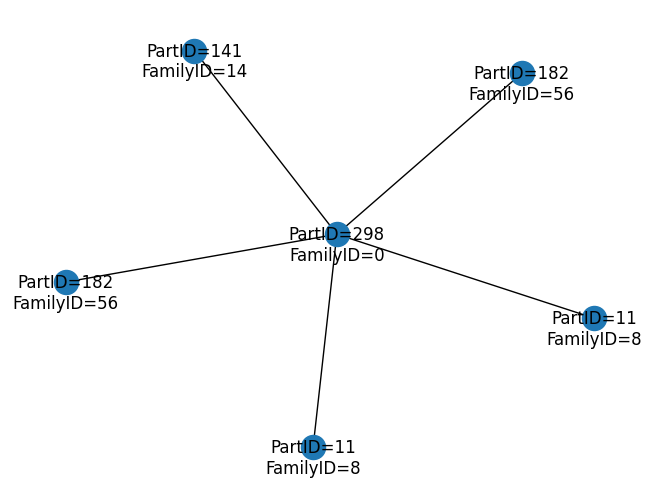

In [9]:
# Load Test Data
with open('data/test_graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

graph = graphs[397]
graph.draw()

# Create Input Tensor
Define a function to create an input tensor using family_ids.

In [10]:
def create_input_tensor(graph: Graph, family_id: int) -> torch.Tensor:
    family_ids_graph = graph.get_parts()
    family_ids_graph = [int(part.get_family_id()) for part in family_ids_graph]

    feature_graph = torch.zeros(size, dtype=torch.float)
    for fid in family_ids_graph:
        feature_graph[fid] = 1

    feature_source_id = torch.zeros(size, dtype=torch.float)
    feature_source_id[family_id] = 1

    input_tensor = torch.cat([feature_graph, feature_source_id])
    
    # Debugging: Print the input tensor
    #print(f"Input tensor for family_id {family_id}: {input_tensor}")
    
    return input_tensor

# Predict Function
Define a function to make predictions using the trained model.

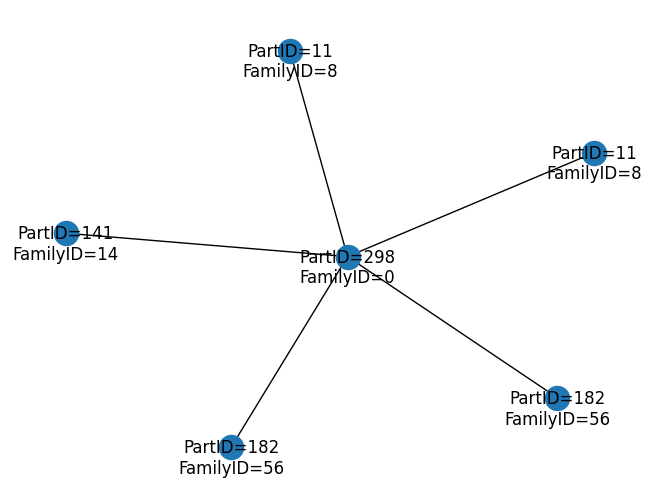

In [11]:
graph.draw()

In [11]:
def predict(model, input_tensor):
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        # Add batch dimension and flatten the input
        #x = input_tensor.unsqueeze(0)  # Add batch dimension
        #x = x.view(1, -1)  # Flatten to (1, input_size)
        output = model(input_tensor)
        #print(output)
        return output.squeeze(0)  # Remove batch dimension from output

# Example usage:
print(graph.get_parts())
input_tensor = create_input_tensor(graph, 51)
prediction = predict(model, input_tensor)
print(prediction)

# If you want to get the most likely edges (e.g., top k predictions)
k = 5  # Number of predictions to return
values, indices = torch.topk(prediction, k)
print(f"Top {k} predicted connections:")
for value, idx in zip(values, indices):
    print(f"Family ID {idx}: probability {value:.4f}")

{Part(PartID=11, FamilyID=8), Part(PartID=11, FamilyID=8), Part(PartID=141, FamilyID=14), Part(PartID=182, FamilyID=56), Part(PartID=182, FamilyID=56), Part(PartID=298, FamilyID=0)}
tensor([9.3903e-14, 9.6990e-39, 2.9582e-14, 1.1080e-31, 1.2794e-27, 1.3608e-21,
        7.3209e-26, 9.6409e-33, 4.4071e-21, 0.0000e+00, 3.1431e-11, 0.0000e+00,
        0.0000e+00, 1.8372e-35, 3.3544e-33, 4.7621e-20, 2.5106e-20, 2.7192e-21,
        1.9923e-31, 0.0000e+00, 0.0000e+00, 5.9088e-24, 6.5996e-39, 0.0000e+00,
        6.8661e-19, 0.0000e+00, 2.1151e-37, 8.5943e-33, 1.6118e-36, 0.0000e+00,
        2.2334e-36, 2.3738e-26, 0.0000e+00, 1.1576e-21, 0.0000e+00, 7.9615e-31,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6299e-33, 5.5268e-07,
        0.0000e+00, 8.5624e-12, 3.3448e-09, 7.0984e-29, 7.4793e-32, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.1614e-22, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.9519e-30, 0.0000e+00, 3.4532e-01, 0.0000e+00, 1.1608e-31, 0.0000e+00,
        0.0000e+00

# Calculate Probabilities
Calculate the matrix of probabilities for family_ids.

{8, 0, 56, 14}
{8: {0: 1.0, 14: 0.0, 56: 2.7989318014650105e-26}, 0: {8: 1.0, 14: 1.0, 56: 1.0}, 56: {0: 1.0, 8: 2.2810203375278678e-23, 14: 2.47154689716968e-34}, 14: {0: 1.0, 8: 0.0, 56: 0.0}}


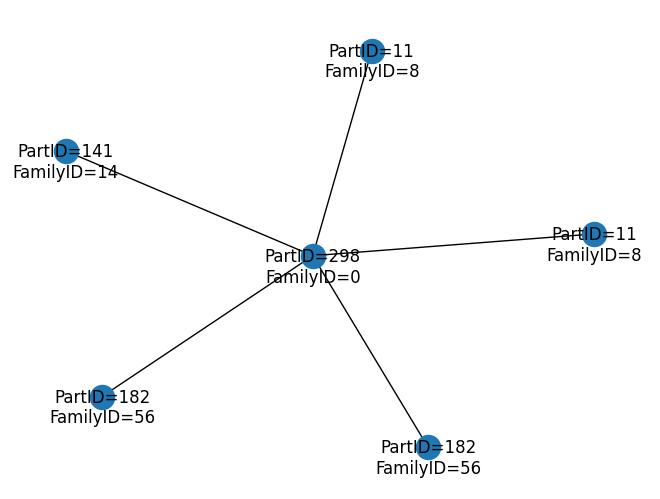

{Node(NodeID=0, Part=Part(PartID=298, FamilyID=0)): [Node(NodeID=4, Part=Part(PartID=11, FamilyID=8)), Node(NodeID=5, Part=Part(PartID=11, FamilyID=8)), Node(NodeID=1, Part=Part(PartID=141, FamilyID=14)), Node(NodeID=2, Part=Part(PartID=182, FamilyID=56)), Node(NodeID=3, Part=Part(PartID=182, FamilyID=56))], Node(NodeID=1, Part=Part(PartID=141, FamilyID=14)): [Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))], Node(NodeID=2, Part=Part(PartID=182, FamilyID=56)): [Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))], Node(NodeID=3, Part=Part(PartID=182, FamilyID=56)): [Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))], Node(NodeID=4, Part=Part(PartID=11, FamilyID=8)): [Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))], Node(NodeID=5, Part=Part(PartID=11, FamilyID=8)): [Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))]}


In [12]:
# Calculate the matrix of probabilities for family_ids

family_ids = [int(part.get_family_id()) for part in graph.get_parts()]
family_id_set = set(family_ids)
print(family_id_set)

# Create a matrix to store the probabilities (dictionary of dictionaries)
probabilities = {family_id: {} for family_id in family_id_set}

for family_id in family_id_set:
    input_tensor = create_input_tensor(graph, family_id)
    prediction = predict(model, input_tensor)
    # Only store the probabilities that are in the family_ids set
    for idx, prob in enumerate(prediction):
        if idx in family_ids and idx != family_id:
            probabilities[family_id][idx] = prob.item()


print(probabilities)
graph.draw()
print(graph.get_edges())

# Print Top Connections
Print the top connections based on the calculated probabilities.

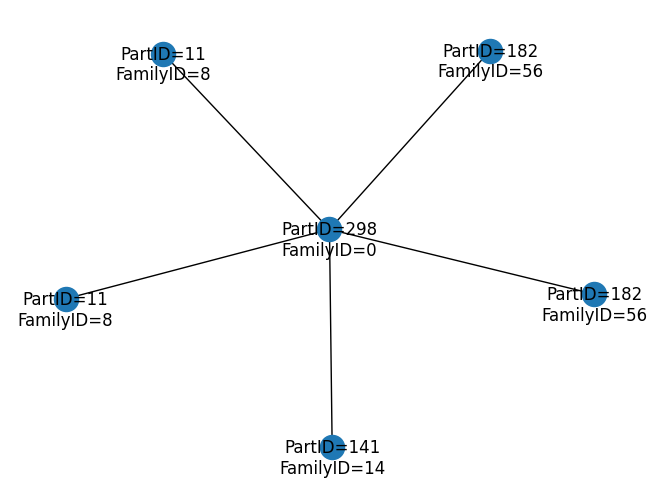

In [13]:
graph.draw()

# Experiment Section

In [15]:
probabilities

{0: {8: 0.998860239982605, 14: 0.9999681711196899, 56: 0.9815974235534668},
 8: {0: 0.9999967813491821,
  14: 1.0778729089498303e-22,
  56: 5.3897233898148045e-11},
 56: {0: 0.9996980428695679,
  8: 5.31775903693521e-13,
  14: 3.644749684810752e-18},
 14: {0: 0.9999991655349731,
  8: 2.0042925671504526e-27,
  56: 7.395450354538702e-13}}

Graph with 6 nodes and 0 edges
[(Node(NodeID=2, Part=Part(PartID=182, FamilyID=56)), Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))), (Node(NodeID=4, Part=Part(PartID=11, FamilyID=8)), Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))), (Node(NodeID=3, Part=Part(PartID=182, FamilyID=56)), Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))), (Node(NodeID=1, Part=Part(PartID=141, FamilyID=14)), Node(NodeID=0, Part=Part(PartID=298, FamilyID=0))), (Node(NodeID=5, Part=Part(PartID=11, FamilyID=8)), Node(NodeID=0, Part=Part(PartID=298, FamilyID=0)))]
Part(PartID=182, FamilyID=56)
Part(PartID=11, FamilyID=8)
Part(PartID=182, FamilyID=56)
Part(PartID=141, FamilyID=14)
Part(PartID=11, FamilyID=8)


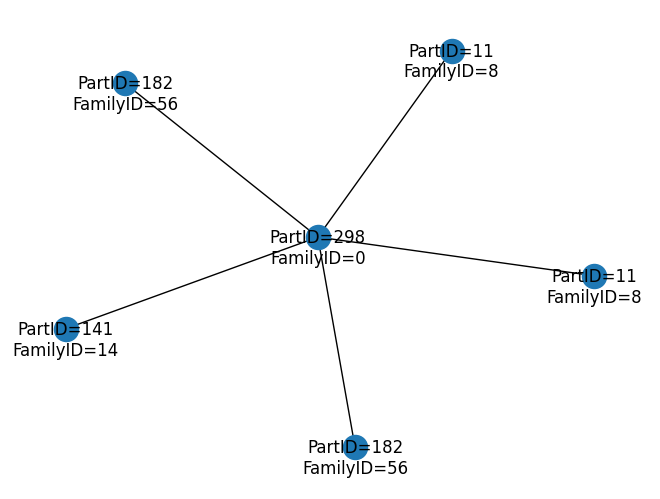

In [14]:
import networkx as nx
import numpy as np
import matplotlib as plt

# Use NetworkX to create the graph

G = graph.to_nx()

# Remove all edges
G.remove_edges_from(list(G.edges))

print(G)


for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 == node2:
            continue
        family_id1 = int(node1.get_part().get_family_id())
        family_id2 = int(node2.get_part().get_family_id())
        prob = probabilities[family_id1].get(family_id2, 0)

        # Weight is the inverse of the probability, so that higher probabilities have lower weights
        weight = 1 - prob

        G.add_edge(node1, node2, weight=weight)

# Find the minimum spanning tree
T = nx.minimum_spanning_tree(G)

predicted_custom_graph = Graph()

print(T.edges)

for edge in T.edges():

    print(edge[0].get_part())
    predicted_custom_graph.add_undirected_edge(edge[0].get_part(), edge[1].get_part())

predicted_custom_graph.draw()
    

In [15]:
## Function to calaculate the probabilities
def calculate_probabilities(model: nn.Module, graph: Graph) -> dict:
    family_ids = [int(part.get_family_id()) for part in graph.get_parts()]
    family_id_set = set(family_ids)

    # Create a matrix to store the probabilities (dictionary of dictionaries)
    probabilities = {family_id: {} for family_id in family_id_set}

    for family_id in family_id_set:
        input_tensor = create_input_tensor(graph, family_id)
        prediction = predict(model, input_tensor)
        # Only store the probabilities that are in the family_ids set
        for idx, prob in enumerate(prediction):
            if idx in family_ids and idx != family_id:
                probabilities[family_id][idx] = prob
    
    return probabilities

# Function to create the predicted graph
def create_predicted_graph(graph: Graph, probabilities: dict) -> Graph:
    G = graph.to_nx()
    G.remove_edges_from(list(G.edges))

    for node1 in G.nodes:
        for node2 in G.nodes:
            if node1 == node2:
                continue
            family_id1 = int(node1.get_part().get_family_id())
            family_id2 = int(node2.get_part().get_family_id())
            prob = probabilities[family_id1].get(family_id2, 0)

            # Weight is the inverse of the probability, so that higher probabilities have lower weights
            weight = 1 - prob

            G.add_edge(node1, node2, weight=weight)

    T = nx.minimum_spanning_tree(G)

    predicted_custom_graph = Graph()

    for edge in T.edges():
        predicted_custom_graph.add_undirected_edge(edge[0].get_part(), edge[1].get_part())

    return predicted_custom_graph

In [16]:
correct_graphs = 0
for graph in graphs:
    probabilities = calculate_probabilities(model, graph)
    predicted_graph = create_predicted_graph(graph, probabilities)
    if graph == predicted_graph:
        correct_graphs += 1

print(f" Exact Match Accuracy: {correct_graphs/len(graphs)}")
    

 Exact Match Accuracy: 0.6518817204301075


In [17]:
# Edge accuracy evaluation
from evaluation import edge_accuracy

sum_correct_edges = 0
edges_counter = 0

for i,graph in enumerate(graphs):
    edges_counter += len(graph.get_edges())
    probabilities = calculate_probabilities(model, graph)
    predicted_graph = create_predicted_graph(graph, probabilities)
    sum_correct_edges += edge_accuracy(graph, predicted_graph)


accuracy = sum_correct_edges / edges_counter

print(f"Edge accuracy: {accuracy}")

ImportError: cannot import name 'MyPredictionModel' from partially initialized module 'evaluation' (most likely due to a circular import) (/Users/bestler/Documents/3.Semester/KI/project/code/evaluation.py)

In [44]:
accuray = sum_correct_edges / edges_counter

In [45]:
accuracy

np.float64(8.216083957313838)

In [70]:
# Total edges
total_edges = 0
for graph in graphs:
    parts = set(graph.get_parts())
    total_edges += len(parts) * len(parts)



In [71]:
accuracy = sum_correct_edges / total_edges

In [72]:
accuracy

np.float64(0.968420394814501)

In [45]:
print(size)

96


In [19]:
from evaluation import evaluate

evaluate(model, graphs, graphs)

NameError: name 'MyPredictionModel' is not defined